# Diverging network

- A network of 100 excitatory cells without any inhibition


In [1]:
# fileName

fileName = 'eg_diverging-network' 

In [2]:
# only spinnaker

In [3]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu
from fooof import FOOOF
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}

import re
def sanitize_filename(s):
    return re.sub(r'[<>:"/\\|?*]', '-', s)  # set di caratteri vietati su Windows
saveName = sanitize_filename(saveName)
print(saveName)


../outputs/eg_diverging-network-2026-02-18T17:09:53.260187
..-outputs-eg_diverging-network-2026-02-18T17-09-53.260187


In [4]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250*1 #ms

In [5]:
# defining the network

pops = {}
n_cells = {}
neuron_Model = {}
neuron_ModelPars = {}
initial_Values = {}

for popName in ['Exc']:
    n_cells[popName] = 100
    neuron_Model[popName] = sim.IF_cond_exp
    neuron_ModelPars[popName] = sim.IF_cond_exp.default_parameters # or standard_pars or testing_pars
    initial_Values[popName] = sim.IF_cond_exp.default_initial_values
    pops[popName] = sim.Population(n_cells[popName], 
                                   neuron_Model[popName],
                                   neuron_ModelPars[popName],
                                   structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                                   label = popName)
                                   # add spatial constraint

    pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh'])   
 
pops

{'Exc': Population(100, IF_cond_exp(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='Exc')}

In [6]:
# defining the list of connections

def compute_manual_list(n_cells_i, n_cells_j, weights, d_thresh, p_thresh, width): 
        v_c = 0.35 #m/s
        d0 = 1 #ms
        scale = 1

        connections = {}
        probabilities = {}
        distances = {}

        connections = []
        probabilities = []
        distances = []
        for pre in range(n_cells_i):
            for post in range(n_cells_j):
                d_ij = np.sqrt((pre - post)**2)
                delay = d0 + d_ij / v_c
                if d_ij > d_thresh: 
                    distances.append(d_ij)
                    p_ij = scale*np.exp(-0.5 * (d_ij**2/width**2))
                    probabilities.append(p_ij)

                    if p_ij > p_thresh:
                        connections.append([pre, post, weights, delay])#, [d_ij, p_ij]])

        return connections, distances, probabilities


In [7]:
# compute manual list of connections 

weight = {('Exc', 'Exc') : 0.08}
          
d_thresh = {('Exc', 'Exc'): 0}

p_thresh = {('Exc', 'Exc'): 0.2}

width = {('Exc', 'Exc'): 1}



connections = {}
distances = {}
probabilities = {}

connections['Exc', 'Exc'], distances['Exc', 'Exc'], probabilities['Exc', 'Exc'] = compute_manual_list(n_cells['Exc'], 
                                                                                                      n_cells['Exc'], 
                                                                                                      weight['Exc', 'Exc'], 
                                                                                                      d_thresh['Exc', 'Exc'], 
                                                                                                      p_thresh['Exc', 'Exc'], 
                                                                                                      width['Exc', 'Exc'])


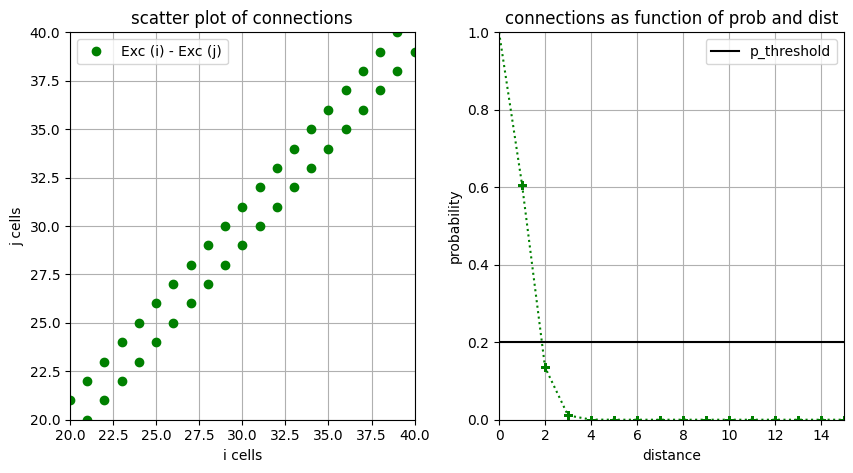

In [8]:
# visual check of the connections

fig, ax = plt.subplots(1,2, figsize=(9,5))
fig.tight_layout(pad=3)
axes_list = fig.axes

axes_list[0].plot(np.asarray(connections['Exc', 'Exc']).T[0], np.asarray(connections['Exc', 'Exc']).T[1],'go', label='Exc (i) - Exc (j)')
axes_list[0].grid()
axes_list[0].legend()
axes_list[0].set_title('scatter plot of connections')
axes_list[0].set_xlabel('i cells')
axes_list[0].set_ylabel('j cells')
axes_list[0].set_xlim(20,40)
axes_list[0].set_ylim(20,40)

axes_list[1].plot(distances['Exc', 'Exc'],probabilities['Exc', 'Exc'],'g+')
axes_list[1].plot(np.arange(0, 50), 1*np.exp(-0.5 * (np.arange(0, 50)**2/width['Exc', 'Exc']**2)), 'g:')
axes_list[1].grid()
axes_list[1].set_xlim(0,15)
axes_list[1].set_ylim(0,1)
axes_list[1].axhline(p_thresh['Exc', 'Exc'], color='k', label='p_threshold', )
axes_list[1].set_title('connections as function of prob and dist')
axes_list[1].set_xlabel('distance')
axes_list[1].set_ylabel('probability')
axes_list[1].legend()


In [9]:
# make the projections

proj = {}



proj['Exc', 'Exc'] = sim.Projection(pops['Exc'], 
                                    pops['Exc'],
                                    connector = sim.FromListConnector(connections['Exc', 'Exc']),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label = 'exc-exc connections'
                                    )


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

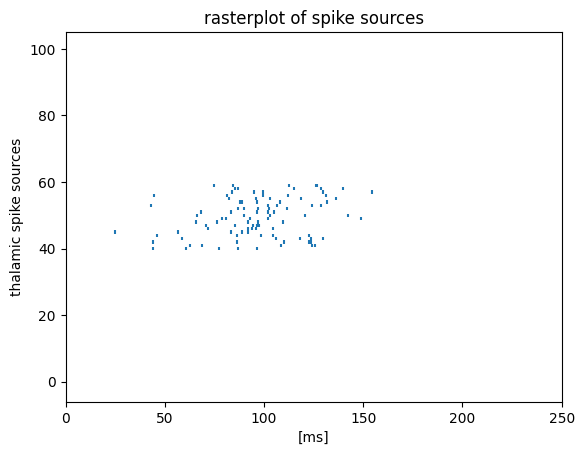

In [10]:
# make the thalamic input sources

popName = 'Thalamus'  

n_cells[popName] = n_cells['Exc']
spike_times = [[]]*n_cells[popName] #list of spike lists, where one spike list is related to one spike source

random_sources_idx = np.arange(int(n_cells[popName]*0.40), int(n_cells[popName]*0.60))

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=100, scale=25)) for n in range(5)])


neuron_Model[popName] = sim.SpikeSourceArray(spike_times=spike_times)


pops[popName] = sim.Population(n_cells[popName], 
                           neuron_Model[popName],
                           label = popName)

proj['Thalamus', 'Exc'] = sim.Projection(pops['Thalamus'], 
                                         pops['Exc'],
                                         connector = sim.OneToOneConnector(),
                                         synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                         receptor_type = 'excitatory',
                                         label = 'thalamus-exc connections')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

In [11]:
# simulation run

tic = time.time()
sim.run(simtime)
toc = time.time() - tic

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.04s, trying other methods took 0.15s). [brian2.stateupdaters.base.method_choice]
WARNING    Note that the synaptic pathway 'synapses_1_pre' will run on the clock of the group 'spikegeneratorgroup' using a dt of 100. us. Either the Synapses object 'synapses_1' or the target 'neurongroup' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 100. us. If in doubt, try to ensure that 'spikegeneratorgroup', 'synapses_1', and 'neurongroup' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


In [12]:
# save results

stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()



In [13]:
# check results

stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()

Exc
gsyn_inh
v
gsyn_exc
Thalamus


dict_keys([('Exc', 'gsyn_inh'), ('Exc', 'v'), ('Exc', 'gsyn_exc'), ('Exc', 'spikes'), ('Thalamus', 'spikes')])

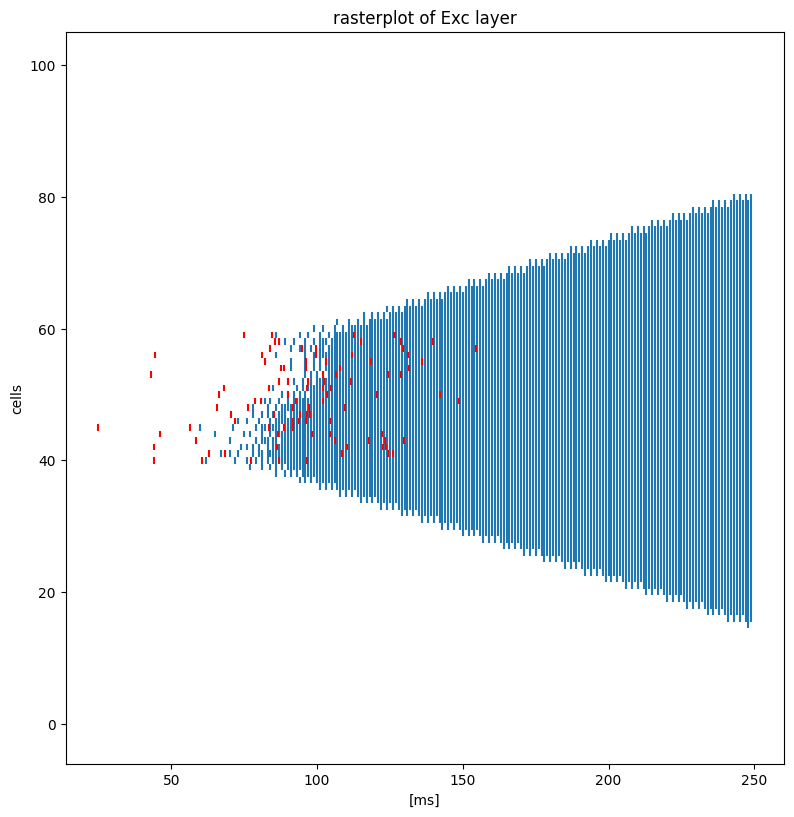

In [14]:
# check the spikes

fig, axes = plt.subplots(1, 1, figsize=(9,9))
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['Exc']):
    axes_list[idx].eventplot(results[value, 'spikes'], label='network')
    axes_list[idx].eventplot(spike_times, color='r', label='thalamus')
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    



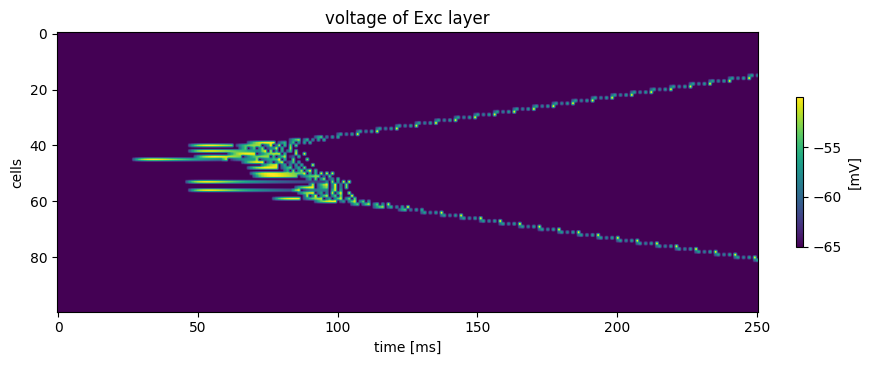

In [15]:
# check the voltage

fig, axes = plt.subplots(1, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['Exc']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')

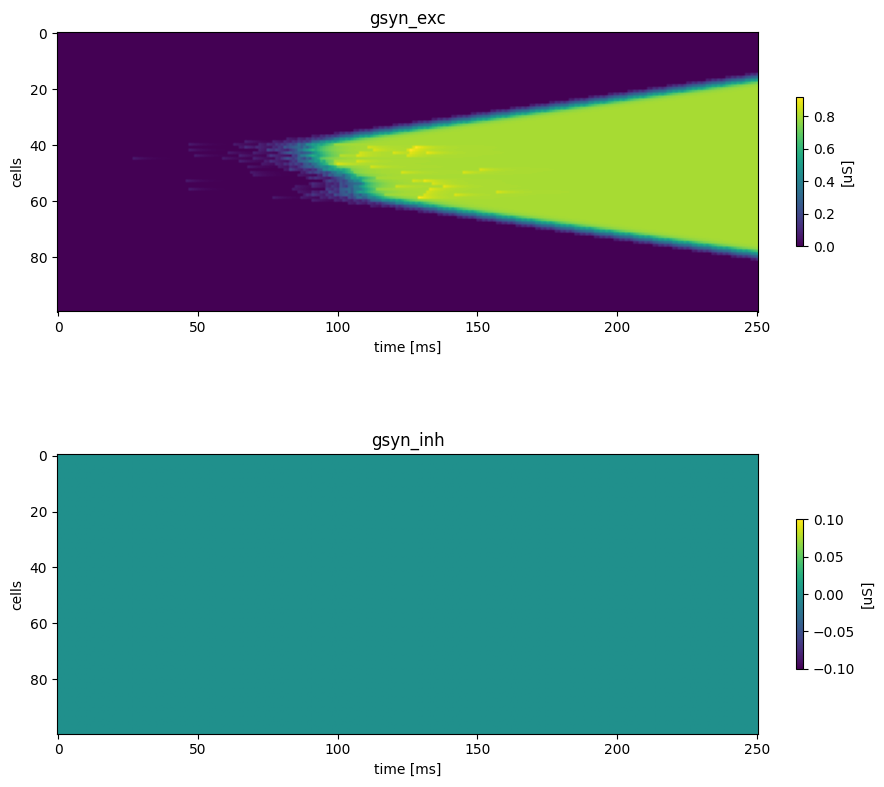

In [16]:
# check the conductances

# check the voltage

fig, axes = plt.subplots(2, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['Exc']):
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results['Exc', gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')

In [17]:
# end simulation

sim.end()

# task 1: on the stimulus

- go to the notebook cell '# make the thalamic input sources' and design and test a new type of thalamic input (e.g., more/sparser input cells, etc)
- add amounts of inhbitory cells by changing their number and their recurrent or feedback connectivity in order to restore the persistent behavior 
